## **Uber Fare Rates in New York City (Before and After 05/09/2012)**

### **Before 05/09/2012 (in USD)**

#### **Normal Trip:**

- Initial Charge: $2
- Surcharge Improvement: $0.30
- Surcharge from 8pm to 6am every day: $0.50
- Surcharge from 4pm to 8pm on weekdays (excluding holidays): $1.00
- Surcharge for drop-off locations (NYC, Nassau, Suffolk, Westchester, Rockland, Dutchess, Orange, Putnam): $0.50

- No surcharge for extra passengers or bags.
- Receipt includes payments for bridges and tunnels.

- Meter Rate:
  - $0.40 per 1/5 mile
  - $0.40 per 60 seconds when the vehicle is stopped.

#### **Airport Trips:**

- To/From La Guardia Airport: Normal Trip
- To/From JFK Airport (any location in NYC excluding Manhattan): Normal Trip
- To/From JFK Airport (any location in Manhattan):
  - Base Fare: $45
  - Additional surcharge (if between 4pm and 8pm on weekdays, excluding holidays): $4.5
  - Tolls apply.

- To Newark Airport: Normal trip + $15

### **After 05/09/2012 (in USD)**

#### **Normal Trip:**

- Initial Charge: $2.50
- Surcharge Improvement: $0.30
- Surcharge from 8pm to 6am every day: $0.50
- Surcharge from 4pm to 8pm on weekdays (excluding holidays): $1.00
- Surcharge for drop-off locations (NYC, Nassau, Suffolk, Westchester, Rockland, Dutchess, Orange, Putnam): $0.50

- No surcharge for extra passengers or bags.
- Receipt includes payments for bridges and tunnels.

- Meter Rate:
  - $0.50 per 1/5 mile
  - $0.50 per 60 seconds when the vehicle is stopped.

#### **Airport Trips:**

- To/From La Guardia Airport: Normal Trip
- To/From JFK Airport (any location in NYC excluding Manhattan): Normal Trip
- To/From JFK Airport (any location in Manhattan):
  - Base Fare: $52.8
  - Additional surcharge (if between 4pm and 8pm on weekdays, excluding holidays): $4.5
  - Tolls apply.

- To Newark Airport: Normal trip + $17.5

# Import stuff

In [15]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import itertools
import math
from math import radians
import warnings
warnings.filterwarnings('ignore')

#Visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)
import seaborn as sns
sns.set_style("darkgrid")
import folium
import folium.plugins
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Using datashader
#Import Libraries
from bokeh.models import BoxZoomTool
from bokeh.plotting import figure, output_notebook, show
import datashader as ds
#from datashader.bokeh_ext import InteractiveImage
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Hot, inferno, Elevation
from datashader import transfer_functions as tf
output_notebook()

Loading BokehJS ...

In [16]:
#!pip install plotly
#!pip install folium
#!pip install bokeh
#!pip install datashader

# Step 1: Data reading and enrichment

In [17]:
def readData(path, types, chunksize, chunks):

    df_list = []
    counter = 1
    
    for df_chunk in tqdm(pd.read_csv(path, usecols=list(types.keys()), dtype=types, chunksize=chunksize)):

        # The counter helps us stop whenever we want instead of reading the entire data
        if counter == chunks+1:
            break
        counter = counter+1

        # Neat trick from https://www.kaggle.com/btyuhas/bayesian-optimization-with-xgboost
        # Using parse_dates would be much slower!
        df_chunk['date'] = pd.to_datetime(df_chunk['pickup_datetime'].str.slice(0,10))
        df_chunk['pickup_datetime'] = df_chunk['pickup_datetime'].str.slice(0, 16)
        df_chunk['pickup_datetime'] = pd.to_datetime(df_chunk['pickup_datetime'])

        # Process the datetime and get hour of day and day of week
        # After Price Reform - Before Price Reform ('newRate')
        df_chunk['hour'] = df_chunk['pickup_datetime'].apply(lambda x: x.hour)
        df_chunk['weekday'] = df_chunk['pickup_datetime'].apply(lambda x: x.weekday())
        df_chunk['newRate'] = df_chunk['pickup_datetime'].apply(lambda x: True if x > pd.Timestamp(2012, 9, 30, 10) else False)
        
        # Aappend the chunk to list
        df_list.append(df_chunk) 

    # Merge all dataframes into one dataframe
    df = pd.concat(df_list)

    # Delete the dataframe list to release memory
    del df_list
    
    return df

We run the function with "chunksnumberTrain = 1" meaning that we only read 1 million datapoints. This is just to make it faster to run, we can use 5 or 10 to make the models more accurate as they have more data but it takes much longer to run.

In [19]:
 # The path where the Training set is
TRAIN_PATH = '/Users/abhishekbhandare/Abhishek/DA/New York Taxi Fare Prediction/new-york-city-taxi-fare-prediction/train.csv'

# The datatypes we want to pass the reading function
traintypes = {'fare_amount': 'float32',
              'pickup_datetime': 'str', 
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'float32'}

# The size of the chunk for each iteration
chunksizeTrain = 1_000_000

# The number of chunks we want to read
chunksnumberTrain = 3

df = readData(TRAIN_PATH, traintypes, chunksizeTrain, chunksnumberTrain)

3it [00:49, 16.54s/it]


# Step 2: Data cleaning

1) Drop the rows with null values  
2) Drop rows with fare_amount less than 2.5 USD  
3) Drop rows with fare_amount above 400 USD  
4) Drop rows with passenger_count outside the range 1 to 6  
5) Drop rows with geolocations not close to NYC    

In [20]:
# 1) Drop NaN
df.dropna(how = 'any', axis = 'rows', inplace = True)

# 2) 3) Drop fares below 2.5 USD or above 400 USD
df = df[df['fare_amount']>=2.5]
df = df[df['fare_amount']<400]
    
# 4) Drop passenger count below 1 or above 6
df = df[(df['passenger_count']>=1) & (df['passenger_count']<=6)] 
    
# 5) Drop rides outside NYC
minLon = -74.3
maxLon = -73.7
minLat = 40.5
maxLat = 41

df = df[df['pickup_latitude'] < maxLat]
df = df[df['pickup_latitude'] > minLat]
df = df[df['pickup_longitude'] < maxLon]
df = df[df['pickup_longitude'] > minLon]

df = df[df['dropoff_latitude'] < maxLat]
df = df[df['dropoff_latitude'] > minLat]
df = df[df['dropoff_longitude'] < maxLon]
df = df[df['dropoff_longitude'] > minLon]

# Reset Index
df.reset_index(inplace=True, drop=True)

# Convert datatype to categorical
df['hour'] = pd.Categorical(df['hour'])
df['weekday'] = pd.Categorical(df['weekday'])
df['passenger_count'] = pd.Categorical(df['passenger_count'])

Let's have a quick look at how many data we loss while cleaning

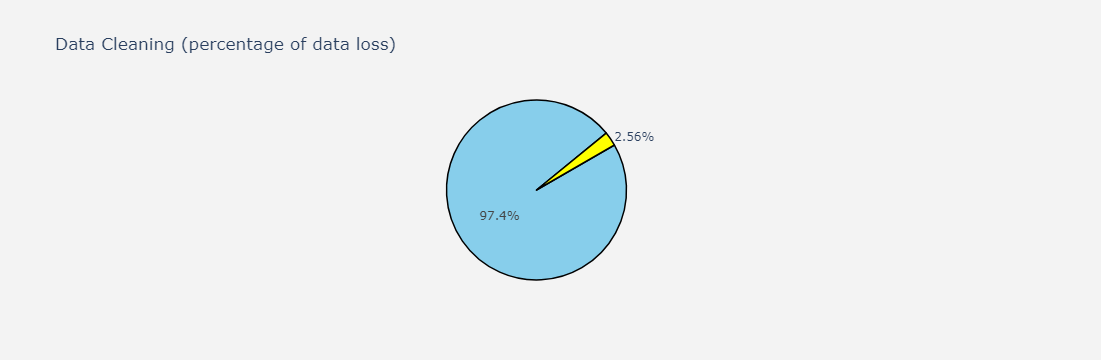

In [21]:
trace = go.Pie(values = [df.shape[0],chunksizeTrain*chunksnumberTrain - df.shape[0]],
               labels = ["Useful data" , "Data loss due to missing values or other reasons"],
               marker = dict(colors = ['skyblue' ,'yellow'], line = dict(color = "black", width =  1.5)),
               rotation  = 60,
               hoverinfo = 'label+percent',
              )

layout = go.Layout(dict(title = 'Data Cleaning (percentage of data loss)',
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        showlegend=False
                       )
                  )

fig = go.Figure(data=[trace],layout=layout)
py.iplot(fig)
fig = go.Figure(data=[trace],layout=layout)

# Step 3: Data Exploration

- Draw all pickup locations using Bokeh and Folium

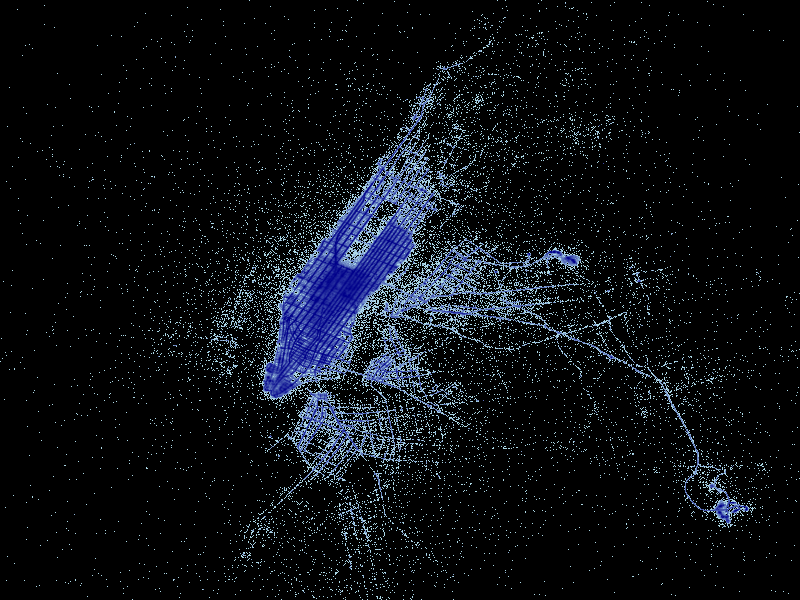

In [22]:
# Define plotting function using Datashader
def plot_data_points(longitude,latitude,data_frame) :
    export  = partial(export_image, export_path="export", background="black")
    fig = figure(background_fill_color = "black")    
    cvs = ds.Canvas(plot_width=800, 
                    plot_height=600,
                    x_range=(-74.15,-73.75), 
                    y_range=(40.6,40.9))
    agg = cvs.points(data_frame,longitude,latitude)
    #img = tf.shade(agg, cmap=Hot, how='eq_hist')
    img = tf.shade(agg)   
    image_xpt = tf.dynspread(img, threshold=0.5, max_px=4)
    return export(image_xpt,'map')

# Call function and plot
plot_data_points('pickup_longitude', 'pickup_latitude', df)

In [23]:
# Let's look at some clusters with Folium (20000 points)
samples = df.sample(n=min(20000,df.shape[0]))
m = folium.Map(location=[np.mean(samples['pickup_latitude']), np.mean(samples['pickup_longitude'])], zoom_start=11)
FastMarkerCluster(data=list(zip(samples['pickup_latitude'], samples['pickup_longitude']))).add_to(m)
folium.LayerControl().add_to(m)
m

- Draw pickup and dropoff locations on airport

In [24]:
# One end has to be JFK
jfk_lat_min = 40.626777
jfk_lat_max = 40.665599
jfk_lon_min = -73.823964
jfk_lon_max = -73.743085

# Filter trips originating on JFK
df_fromJFK = df[(df['pickup_latitude']<jfk_lat_max)&
            (df['pickup_latitude']>jfk_lat_min)&
            (df['pickup_longitude']<jfk_lon_max)&
            (df['pickup_longitude']>jfk_lon_min)]

# Filter trips ending on JFK
df_toJFK = df[(df['dropoff_latitude']<jfk_lat_max)&
           (df['dropoff_latitude']>jfk_lat_min)&
           (df['dropoff_longitude']<jfk_lon_max)&
           (df['dropoff_longitude']>jfk_lon_min)]

m1 = folium.Map(location=[40.645580, -73.785115], zoom_start=16)
samples = df_fromJFK.sample(n=min(500,df_fromJFK.shape[0]))
for lt, ln in zip(samples['pickup_latitude'], samples['pickup_longitude']):
            folium.Circle(location = [lt,ln] ,radius = 2, color = 'blue').add_to(m1)
            
samples = df_toJFK.sample(n=min(500,df_toJFK.shape[0]))
for lt, ln in zip(samples['dropoff_latitude'], samples['dropoff_longitude']):
            folium.Circle(location = [lt,ln] ,radius = 2, color = 'red').add_to(m1)
        
m1

In [26]:
!pip install shapely

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 6.3 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: pip install --upgrade pip


- Filter rides inside Manhattan using polygons

In [27]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

# Define polygon using coordinates (Just took them from Google Maps by clicking on the map)
lats_vect = [40.851638, 40.763022, 40.691262, 40.713380, 40.743944, 40.794344, 40.846332]
lons_vect = [-73.952423, -74.010418, -74.026685, -73.972200, -73.962051, -73.924073, -73.926454]
lons_lats_vect = np.column_stack((lons_vect, lats_vect))
polygon = Polygon(lons_lats_vect)

# Plot the polygon using Folium
man_map = folium.Map(location=[40.7631, -73.9712], zoom_start=12)
for i in range(0,6):
    folium.PolyLine(locations=[[lats_vect[i],lons_vect[i]], [lats_vect[i+1],lons_vect[i+1]]], color='blue').add_to(man_map)
folium.PolyLine(locations=[[lats_vect[6],lons_vect[6]], [lats_vect[0],lons_vect[0]]], color='blue').add_to(man_map)
man_map

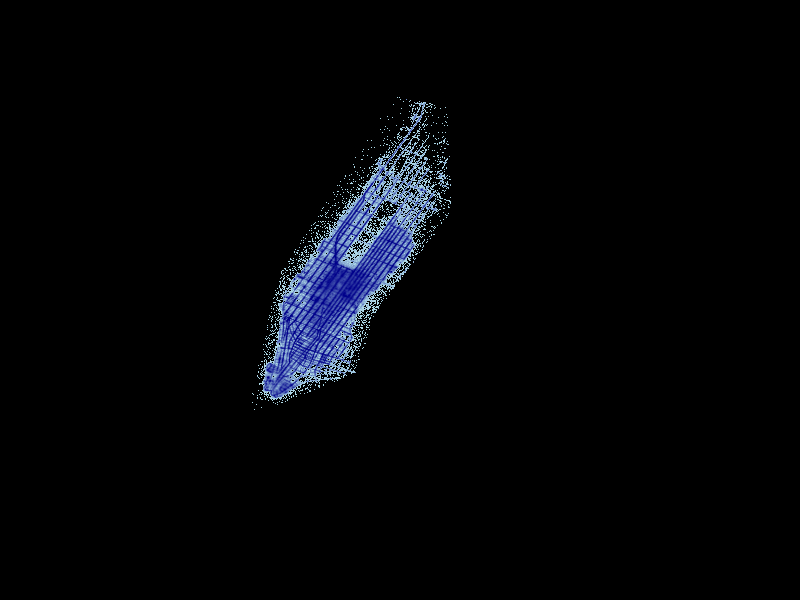

In [10]:
# Check for every point on df_train if it belongs to polygon or not
manhattanRides = df[df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']]
                          .apply(lambda row: ((polygon.contains(Point(row['pickup_longitude'],row['pickup_latitude']))) &
                                              (polygon.contains(Point(row['dropoff_longitude'],row['dropoff_latitude'])))), axis=1)]

# Plot the remaining dataset 'manhattanRides'
plot_data_points('pickup_longitude', 'pickup_latitude', manhattanRides)

In [11]:
print('Percentage of trips that happen inside Manhattan: ' + str(np.around(100*(manhattanRides.shape[0])/df.shape[0],2)))

Percentage of trips that happen inside Manhattan: 85.19


- Calculate distance and add it as a feature

In [28]:
# Simple Euclidean Distance calculator 
def quickDist(lat1, lng1, lat2, lng2):
    lng1, lat1, lng2, lat2 = map(radians, [lng1, lat1, lng2, lat2])
    R = 6371
    x = (lng2 - lng1) * np.cos(0.5*(lat2+lat1))
    y = lat2 - lat1
    d = R * np.sqrt(x*x + y*y)
    return d

# Longitude distance (use same Euclidean distance function with fixed latitude)
def latDist(lat1, lng1, lat2, lng2):
    uno = quickDist((lat1+lat2)/2, lng1, (lat1+lat2)/2, lng2)
    return uno

# Calculate real distance (Manhattan distance with 29 degrees to north)
def realManDist(lat1, lng1, lat2, lng2):
    flightDist = quickDist(lat1, lng1, lat2, lng2)
    latDistance = latDist(lat1, lng1, lat2, lng2)
    if flightDist == 0:
        ret = np.nan
    else:
        th = np.arccos(latDistance/flightDist)
        ata = flightDist*np.cos(th-0.506) + flightDist*np.sin(th-0.506)
        bta = flightDist*np.cos(th+0.506) + flightDist*np.sin(th+0.506)
        ret = max(ata,bta)
    return ret

In [30]:
# Calculate distance for every ride on manhattanRides
manhattanRides['distance'] = manhattanRides.apply(lambda row: realManDist(row['pickup_latitude'], 
                                                                          row['pickup_longitude'], 
                                                                          row['dropoff_latitude'], 
                                                                          row['dropoff_longitude']), axis=1)

NameError: name 'manhattanRides' is not defined

In [34]:
# Drop rows with distance = NaN
manhattanRides.dropna(inplace=True)

# Drop rows with distance below 0.3 (300 meters)
manhattanRides = manhattanRides[manhattanRides['distance']>=0.3]

NameError: name 'manhattanRides' is not defined

In [35]:
# Download manhattanRides dataset as csv
manhattanRides.to_csv('manhattanRides.csv',index=False)

NameError: name 'manhattanRides' is not defined

From now on we use the dataset that contains the Manhattan rides only

- Plot histogram for the fare_amount, devided in 3 sections so it's easier to see what is going on

1) Up to 40 USD (most of the rides)  
2) From 40 USD to 70 USD (rides including airports)  
3) Above 70 USD (expensive rides)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



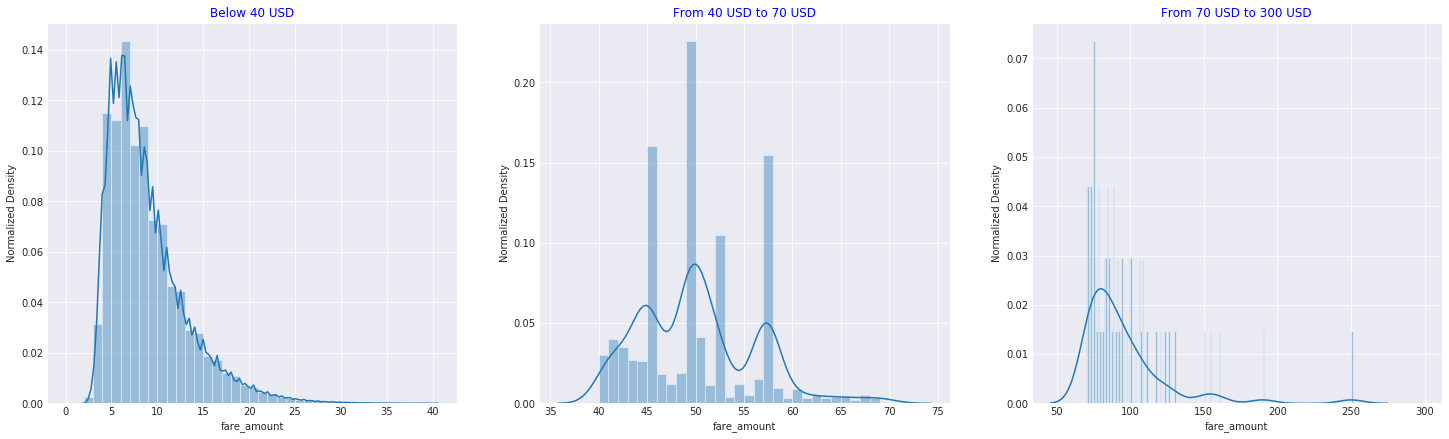

In [16]:
# Define how we want to split the data into sections based on 'fare_amount'
a = 40
b = 70
c = 300

# Plot normalized histogram for each section
plt.figure(figsize = (25,7))
plt.subplot(1,3,1)
plt.title('Below ' + str(a) + ' USD',color = "b")
plt.ylabel('Normalized Density')
sns.distplot(manhattanRides[manhattanRides['fare_amount']<=a]['fare_amount'], norm_hist=True, bins=np.arange(0,a))
plt.subplot(1,3,2)
plt.title('From ' + str(a) + ' USD to ' + str(b) + ' USD',color = "b")
plt.ylabel('Normalized Density')
sns.distplot(manhattanRides[(manhattanRides['fare_amount']>a)&(df['fare_amount']<=b)]['fare_amount'], norm_hist=True, bins=np.arange(a,b))
plt.subplot(1,3,3)
plt.title('From ' + str(b) + ' USD to ' + str(c) + ' USD',color = "b")
plt.ylabel('Normalized Density')
sns.distplot(manhattanRides[(manhattanRides['fare_amount']>b)&(df['fare_amount']<=c)]['fare_amount'], norm_hist=True, bins=np.arange(b,c));

 - Calculate mean and median of the fare_amount before and after the fare change

In [17]:
# Split df_train into a dataset of the rides before the fare rules change and after the fare rules change
df_before = manhattanRides[manhattanRides['newRate']==False]
df_after = manhattanRides[manhattanRides['newRate']==True]
print('Mean fare BEFORE rate change: ' + str(np.around(df_before['fare_amount'].mean(),2)))
print('Mean fare AFTER rate change: ' + str(np.around(df_after['fare_amount'].mean(),2)))
print('Median fare BEFORE rate change: ' + str(np.around(df_before['fare_amount'].median(),2)))
print('Median fare AFTER rate change: ' + str(np.around(df_after['fare_amount'].median(),2)))

Mean fare BEFORE rate change: 8.2
Mean fare AFTER rate change: 9.8
Median fare BEFORE rate change: 7.3
Median fare AFTER rate change: 8.5


- Plot mean fare_amount grouped by hour
- Plot mean fare_amount grouped by weekday
- Plot mean fare_amount grouped by passenger_count

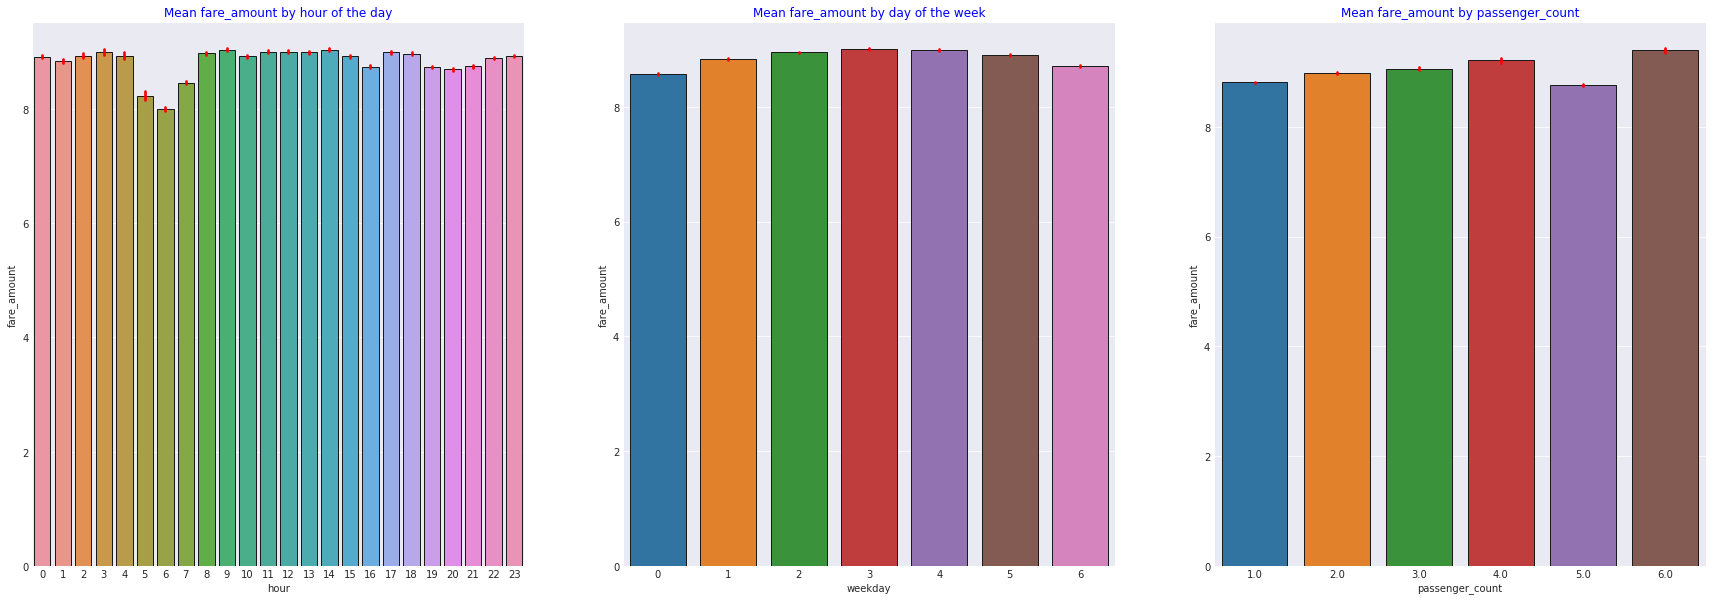

In [18]:
plt.figure(figsize = (30,10))
plt.subplot(1,3,1)
plt.title('Mean fare_amount by hour of the day',color = "b")
ax = sns.barplot(x='hour',y='fare_amount', data = manhattanRides, edgecolor=".1", errcolor = 'red')
plt.subplot(1,3,2)
plt.title('Mean fare_amount by day of the week',color = "b")
ax = sns.barplot(x='weekday',y='fare_amount', data = manhattanRides, edgecolor=".1", errcolor = 'red')
plt.subplot(1,3,3)
plt.title('Mean fare_amount by passenger_count',color = "b")
ax = sns.barplot(x='passenger_count',y='fare_amount', data = manhattanRides, edgecolor=".1", errcolor = 'red')

- Plot time series for the fare_amount with moving average

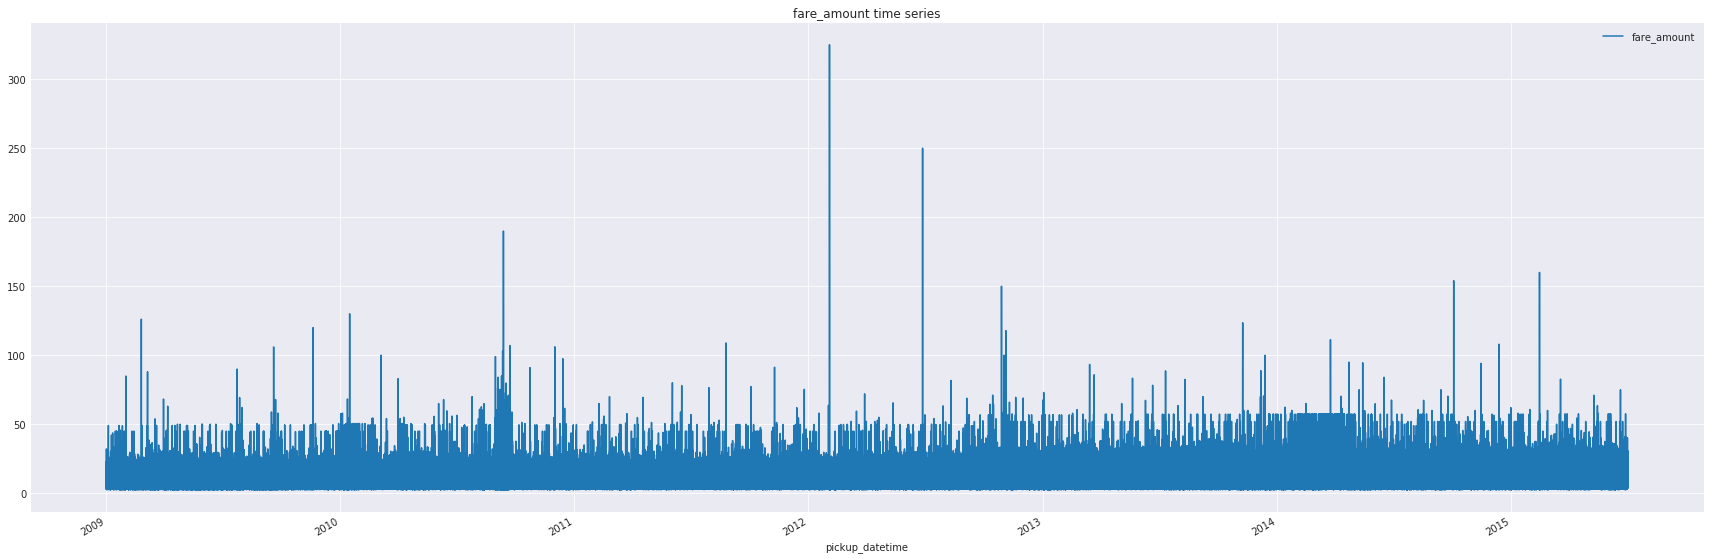

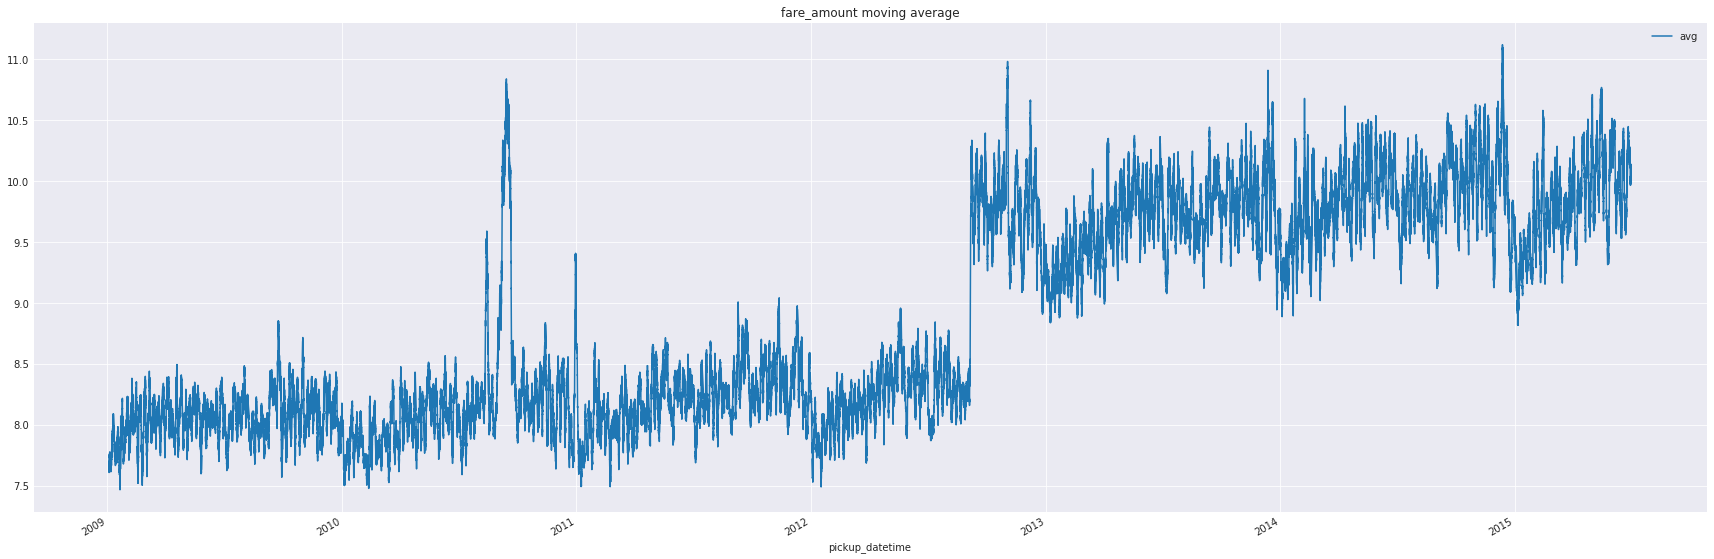

In [19]:
df_sorted = manhattanRides.sort_values('pickup_datetime')
df_sorted.reset_index(inplace=True, drop=True)
mvavg = df_sorted.rolling(window=2000, on='pickup_datetime')['fare_amount'].mean()
mvavg_pd = pd.DataFrame(columns=['avg', 'pickup_datetime'])
mvavg_pd['avg'] = mvavg
mvavg_pd['pickup_datetime'] = df_sorted['pickup_datetime']

df_sorted.plot('pickup_datetime','fare_amount', figsize=(30,10), title='fare_amount time series')
mvavg_pd.plot('pickup_datetime','avg', figsize=(30,10), title='fare_amount moving average');

- Analyze the cents value distribution before and after the fare change (notice how after the fare change only .00 or .50 is possible)

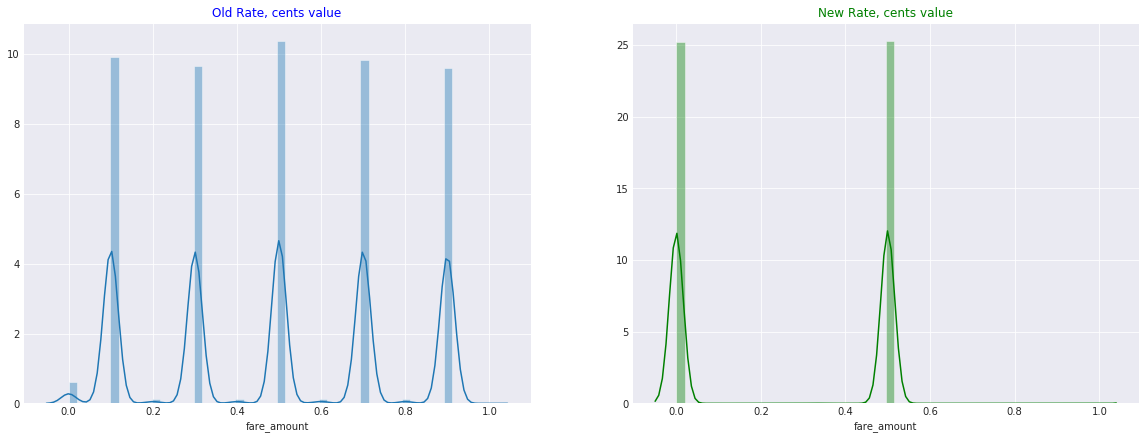

In [20]:
plt.figure(figsize = (20,7))
plt.subplot(1,2,1)
plt.title('Old Rate, cents value',color = "b")
sns.distplot(np.mod(df_before['fare_amount'],1)) 
plt.subplot(1,2,2)
plt.title('New Rate, cents value',color = "g")
sns.distplot(np.mod(df_after['fare_amount'],1), color='green');

# Step 4: fare_amount VS distance, regression models

- Let's first plot the fare_amount as a function of the distance, we see that of course the fare_amount increases as the distance increases but it doesn't look like we have a very good linear relationship. There are also "weird lines" at specific fare amounts, at the same values that we saw on the histogram.

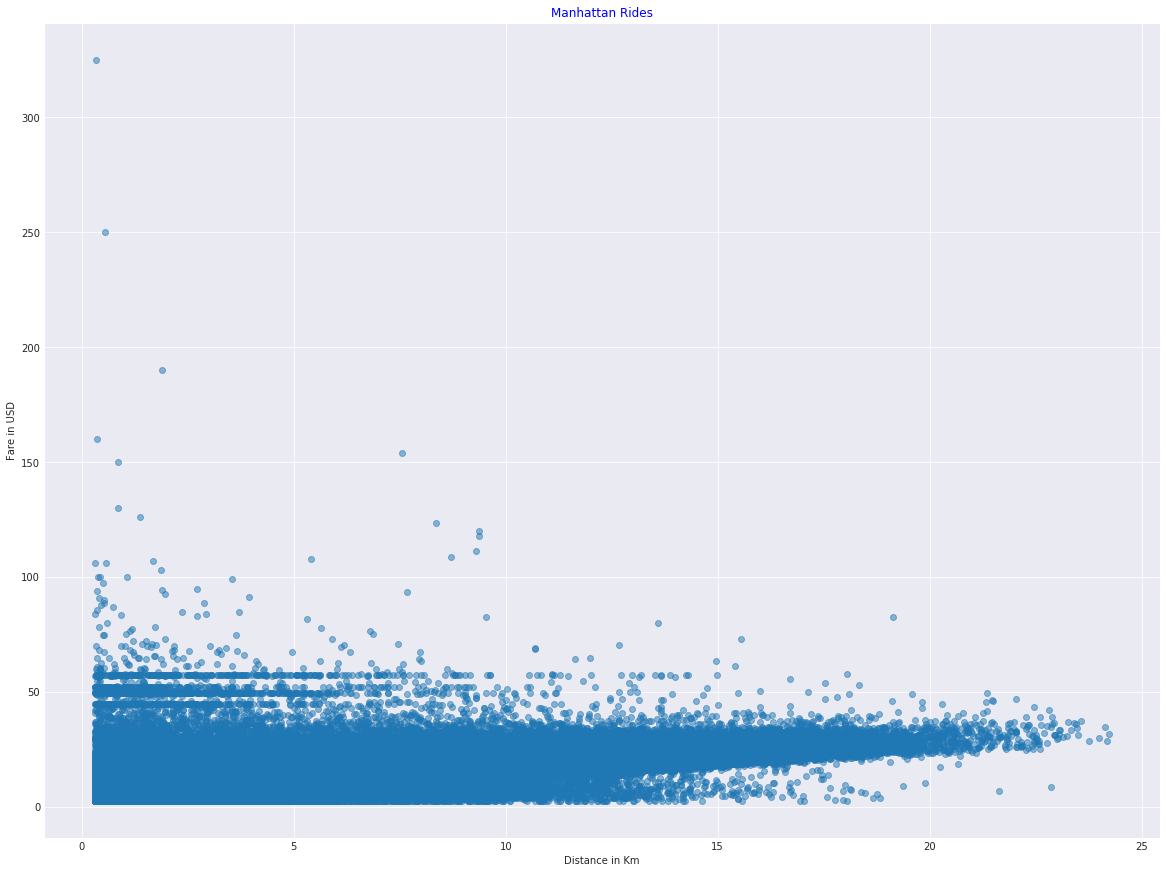

In [21]:
# Plot the 'fare_amount' against the distance of the trip
plt.figure(figsize = (20,15))
plt.title('Manhattan Rides', color = "b")
plt.ylabel('Fare in USD')
plt.xlabel('Distance in Km')
plt.scatter(manhattanRides['distance'], manhattanRides['fare_amount'], alpha=0.5);

Anyway we will try to fit a linear model and see what happens. We will first do a train/test split and then we will also split the dataset into "before the fare change" and "after the fare change" in order to fit a linear model to each of them.

What do we expect? Based on the fare rules the relationship between the fare and the distance is 0.40 USD per 1/5 mile before the change and 0.50 USD per 1/5 mile after the change. If we translate that to kilometers we get that the relationship is 1.243 USD per kilometer before the change and 1.553 USD per kilometer after the change. Let's see what our linear regression gives us (we should look at the slope of the regression): 

In [22]:
# Split train/test
from sklearn.model_selection import train_test_split
manhattanRides_train, manhattanRides_test = train_test_split(manhattanRides, test_size=0.2, random_state=42)

# Split before and after
manhattanRides_train_before = manhattanRides_train[manhattanRides_train['newRate']==0]
manhattanRides_train_after = manhattanRides_train[manhattanRides_train['newRate']==1]
manhattanRides_test_before = manhattanRides_test[manhattanRides_test['newRate']==0]
manhattanRides_test_after = manhattanRides_test[manhattanRides_test['newRate']==1]

In [23]:
# Fitting a linear model and measuring the MSE
import statsmodels.api as sm
# Define function that makes regression and returns params
def measureMSE(df_train, df_test):
    regression = sm.OLS(df_train['fare_amount'], sm.add_constant(df_train['distance'])).fit()
    farepred = regression.predict(sm.add_constant(df_test['distance'])) 
    mse = np.around(np.sqrt((((df_test['fare_amount']-farepred)**2).sum())/(df_test.shape[0])),4)
    return [regression.params[1], regression.params[0], mse]

In [24]:
# Apply function on manhattanRides_train
reg_before = measureMSE(manhattanRides_train_before, manhattanRides_test_before)
reg_after = measureMSE(manhattanRides_train_after, manhattanRides_test_after)

print('Before fare rule change:')
print ('Slope: ' + str(np.around(reg_before[0],2)))
print ('Intercept: ' + str(np.around(reg_before[1],2)))
print ('RMSE: ' + str(np.around(reg_before[2],4)))

print(' ')

print('After fare rule change:')
print ('Slope: ' + str(np.around(reg_after[0],2)))
print ('Intercept: ' + str(np.around(reg_after[1],2)))
print ('RMSE: ' + str(np.around(reg_after[2],4)))

Before fare rule change:
Slope: 1.29
Intercept: 3.86
RMSE: 2.3899
 
After fare rule change:
Slope: 1.67
Intercept: 4.24
RMSE: 2.8454


That is really great. By doing this simple regression we manage to overcome the noise, the traffic, the overcharges and all the other variables that affect the final fare and get a slope (fare dependency on distance) that is pretty close to the fare rules.

# Step 5: Use the other features to make a better model

Our features to make the model:
- hour (categorical)
- weekday (categorical)
- passenger_count (categorical)
- distance (continuous)

Our target:
- fare_amount (continuous)

We will just run a Gradient Boosting Machine for each of the datasets (before and after) without too much tuning or optimization. We see that in both cases the mean RMSE is better than the one we obtained using the linear regression. This could mean that Gradient Boosting performs better than linear regression for this task and/or that the other features contain information and that they help us predict the fare.

In [25]:
import h2o
h2o.init();

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_212"; OpenJDK Runtime Environment (build 1.8.0_212-8u212-b01-1~deb9u1-b01); OpenJDK 64-Bit Server VM (build 25.212-b01, mixed mode)
  Starting server from /opt/conda/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpb4lx3x_6
  JVM stdout: /tmp/tmpb4lx3x_6/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpb4lx3x_6/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.2
H2O cluster version age:,1 month and 29 days
H2O cluster name:,H2O_from_python_unknownUser_sfw4ki
H2O cluster total nodes:,1
H2O cluster free memory:,2.889 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"accepting new members, healthy"


In [26]:
h20_train_before = h2o.H2OFrame(manhattanRides_train_before)
h20_test_before = h2o.H2OFrame(manhattanRides_test_before)
h20_train_after = h2o.H2OFrame(manhattanRides_train_after)
h20_test_after = h2o.H2OFrame(manhattanRides_test_after)

# Define feature space and label space
myCat = ['hour', 'weekday']
myNum = ['distance', 'passenger_count']
myResponse = 'fare_amount'

for i in myCat:
    h20_train_before[i] = h20_train_before[i].asfactor()
    h20_test_before[i] = h20_test_before[i].asfactor()
    h20_train_after[i] = h20_train_after[i].asfactor()
    h20_test_after[i] = h20_test_after[i].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [27]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
model_before = H2OGradientBoostingEstimator(nfolds=5, seed=42, stopping_metric = "MSE")
model_after = H2OGradientBoostingEstimator(nfolds=5, seed=42, stopping_metric = "MSE")

In [28]:
model_before.train(x=myNum+myCat,y=myResponse, training_frame=h20_train_before, validation_frame=h20_test_before)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [29]:
model_after.train(x=myNum+myCat,y=myResponse, training_frame=h20_train_after, validation_frame=h20_test_after)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [30]:
print('Before fare rule change:')
print ('RMSE: ' + model_before.cross_validation_metrics_summary().cell_values[5][1])

print(' ')

print('After fare rule change:')
print ('RMSE: ' + model_after.cross_validation_metrics_summary().cell_values[5][1])

Before fare rule change:
RMSE: 2.304651
 
After fare rule change:
RMSE: 2.6600854


Let's now take a look at the feature importance to see what besides the distance is helping us with the predictions. We see that the distance is the most important feature by far, accounting for >95% of the information. The next important feature in both models is the hour of the day, after that the day of the week and finally the number of passengers, which makes total sense with our intuition.

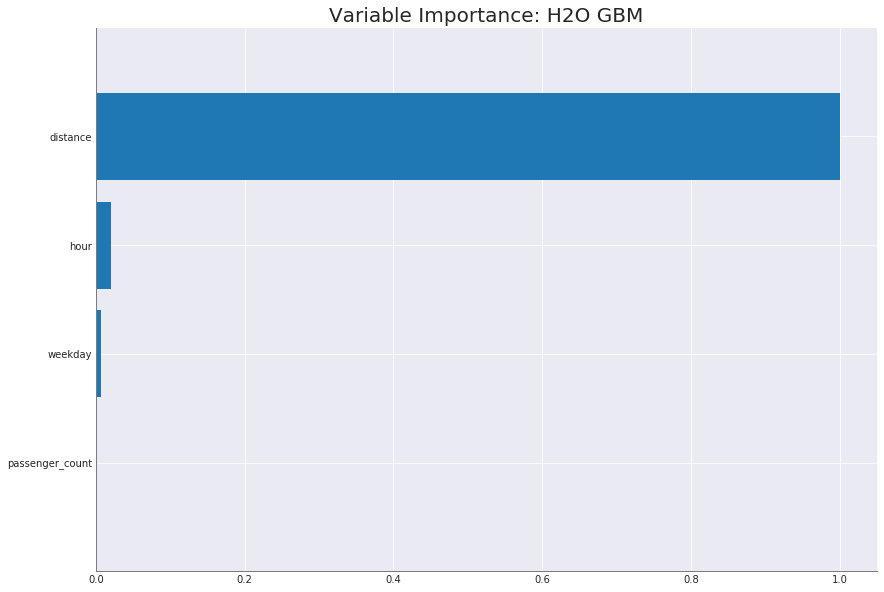

In [31]:
model_before.varimp_plot()

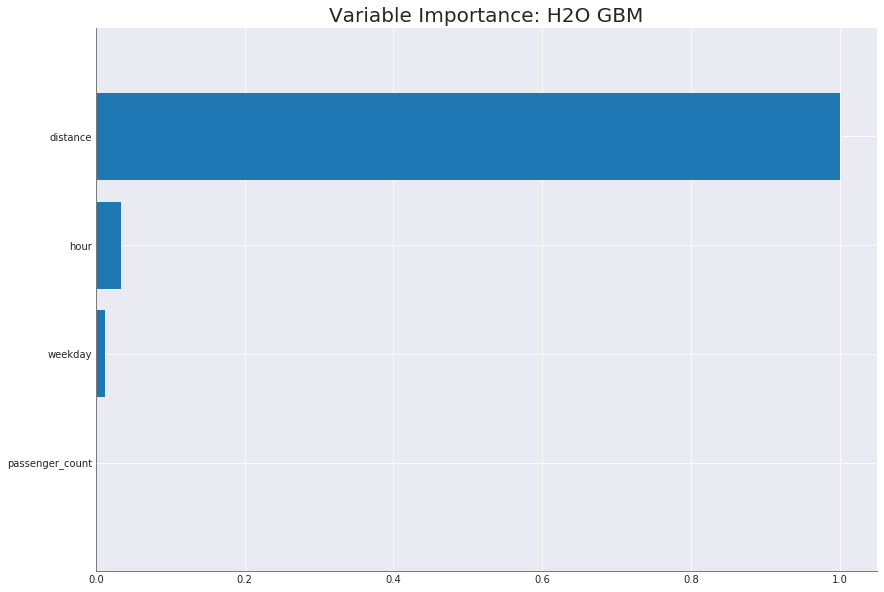

In [32]:
model_after.varimp_plot()

# Step 6: Demand model

Formulate the demand function model. To do this we group our data by day, and we compute the average price per kilometer paid on that day and the total amount of kilometers sold that day. That way we have a product called “a kilometer of taxi ride” where the price of the product changes every day and the total amount of units sold also changes everyday. 

There is an important difference to what we’ve done so far until now, since before this step we computed the “price per kilometer” by fitting a regression and allowing for a constant (intercept of the regression) to absorb all the other things that the final price of the ride is dependent on (initial charge, waiting time, etc). We just looked at the coefficient of the price per kilometer feature and saw that it’s consistent with the fare rules.

Here instead, we look at every taxi ride as if the ONLY thing that determines the final price is the amount of kilometers driven. We can picture this as if the owner of the taxi company is evaluating a new price policy were only the distance traveled determines the fare of the ride, nothing else. He wants to know what the price per kilometer should be under this policy, and what is the elasticity of his customers to changes on the price per kilometer.

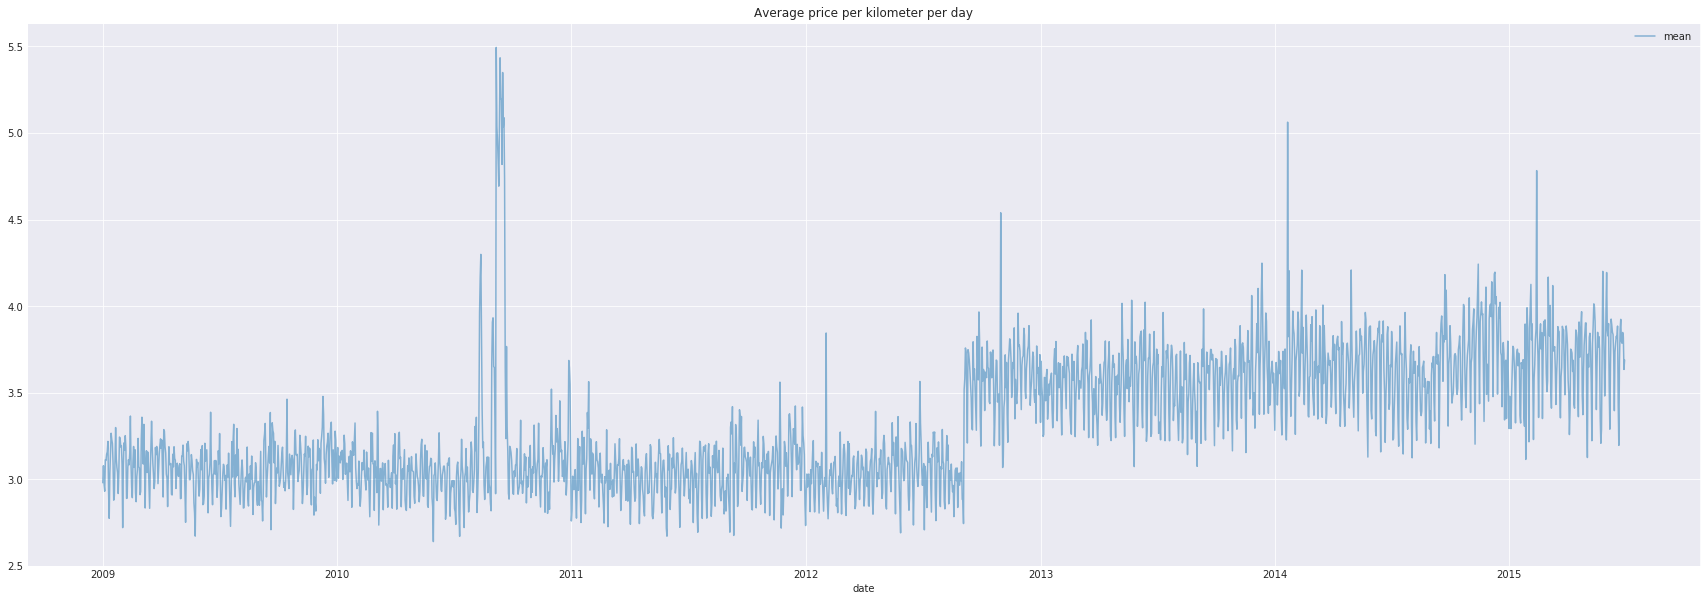

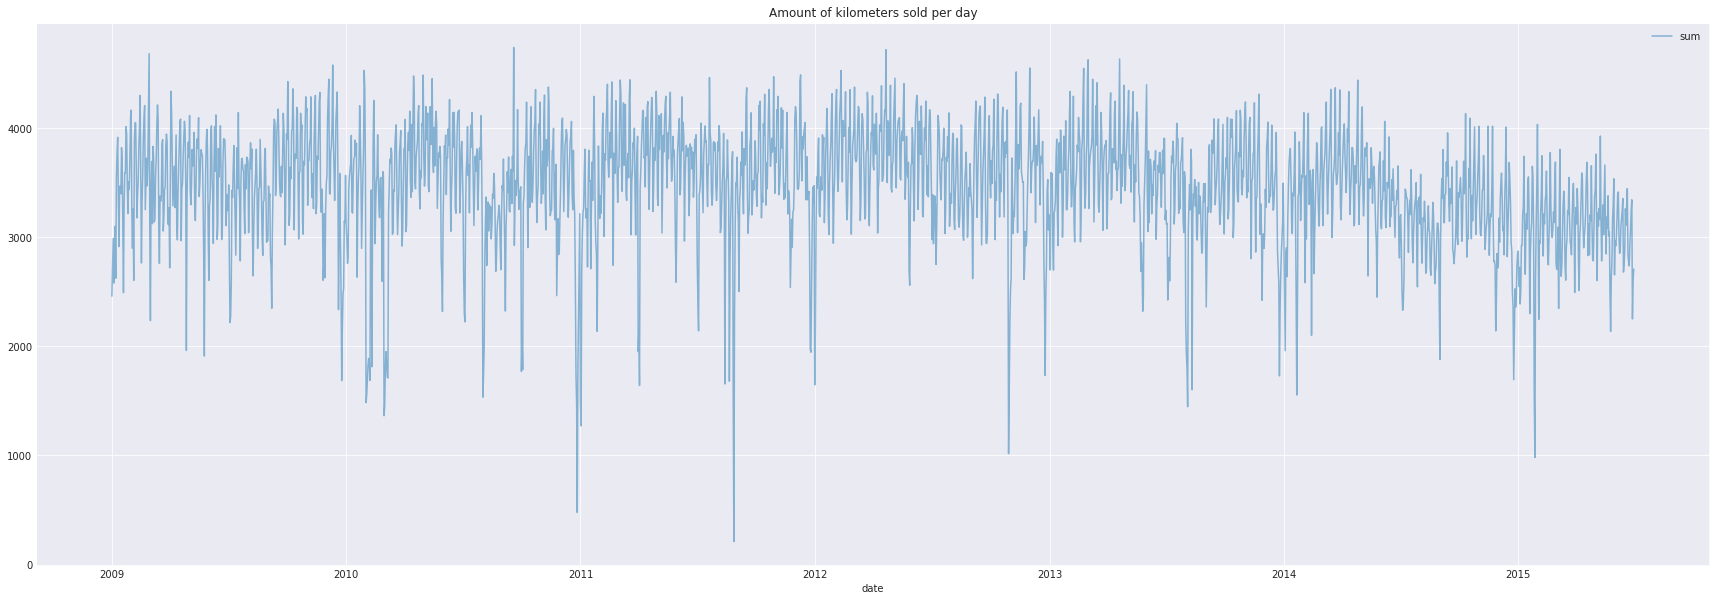

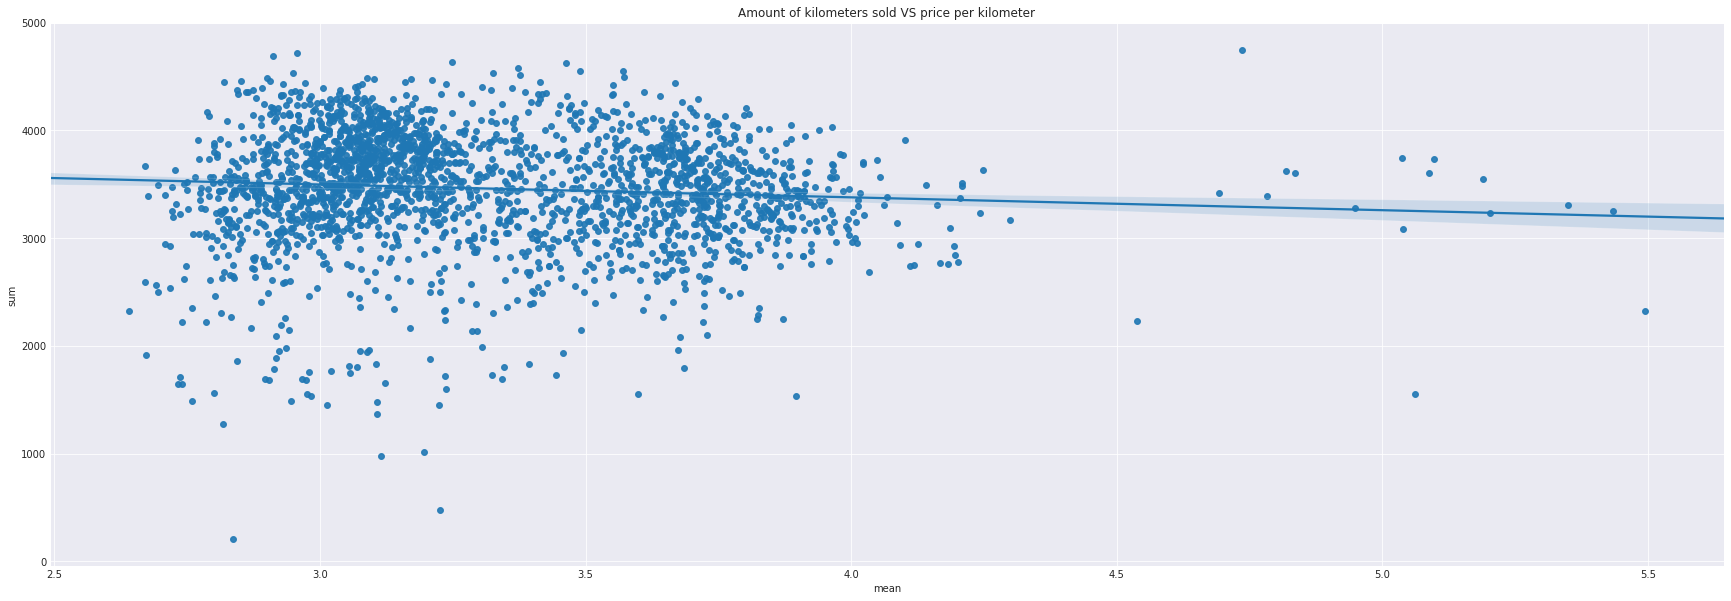

In [33]:
df_demand = manhattanRides[['fare_amount', 'date', 'hour', 'distance']]
df_demand['fare/distance'] = df_demand['fare_amount']/df_demand['distance']
df_demand = df_demand[['date', 'distance', 'fare/distance']]
df_demand = df_demand.groupby('date').agg({'fare/distance':'mean', 'distance':'sum'})
df_demand.reset_index(inplace=True)  
df_demand.columns = ['date', 'mean', 'sum']
df_demand.plot('date', 'mean', figsize=(30,10), alpha=0.5, title='Average price per kilometer per day');
df_demand.plot('date', 'sum', figsize=(30,10), alpha=0.5, title='Amount of kilometers sold per day')
df_demand.plot.scatter('mean', 'sum', figsize=(30,10), alpha=0.5, title='Amount of kilometers sold VS price per kilometer');
sns.regplot(x="mean", y="sum", data=df_demand)

In [34]:
# The regression coefficients are:
print('Slope: ' + str(np.around(sm.OLS(df_demand['sum'], sm.add_constant(df_demand['mean'])).fit().params[1], 4)))
print('Intersect: ' + str(np.around(sm.OLS(df_demand['sum'], sm.add_constant(df_demand['mean'])).fit().params[0], 4)))

Slope: -119.2332
Intersect: 3855.002


The first graph is the prices of our pruduct. We as taxi company owners changed the price per kilometer a little bit every day to see what happens. Also, on a specific point in time we started to be more expensive but still changing the price a little bit every day.

The second graph is the amount of kilometers we sold every day. It's quite noisy and not much can be appreciated with the nude eye. It seems to be that after we decided to increase the price per kilometer the number of kilometers sold started to go down a bit.

The third graph is the relationship between the number of kilometers sold and the price of the kilometer. We see that there is a slight trend down, meaning that the more expensive our product is the less we sell. But it also seems like customers have a lot of eleasticity, the demand doesn't drop that hard when increasing prices. We can see this by looking on how small the slope is compared to the intersect.

We see that most of the datapoints are around 3 to 4 USD, meaning that "the taxi company owner" guessed that if he were to charge based on travelled distance ONLY he should charge about 3 or 4 USD per kilometer, and he is doing this experiment to see how does it affect the demand. *** This is a nice story to convince myself, haha ***

We know that given a linear model, the price were revenue is maximized (the optimal price) can be obtained by doing  
p_opt = - inters****ect/(2*slope)

In our case that would give p_opt around 14 USD... It doesn't make sense of course to charge 14 USD per kilometer for a taxi ride, and that is because it doesn't make sense to fit our demand model to a linear regression. Maybe it's linear on some segment of the price, but expecting it to stay linear while we keep raising and raising the price doesn't make sense.

### Online learning from data generated by the linear model and random noise

First we will run the algorithm we used for the homework. We know the "true" values of alpha and beta based on the regression that we did before so we can run and see what happens (it works, we get the optimal price and the values of alpha and beta as expected). 

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Initial Parameters
alpha = sm.OLS(df_demand['sum'], sm.add_constant(df_demand['mean'])).fit().params[0]
beta = -sm.OLS(df_demand['sum'], sm.add_constant(df_demand['mean'])).fit().params[1]
initial_p = 2
sigma = 1

# Model
def model(p):
    val = alpha - beta*p + np.random.normal(0,1)
    return val

# Regression function
def regression(p_list, D_list):
    reg = LinearRegression(fit_intercept=False).fit(p_list, D_list)
    return reg.coef_

# Performance accummulator
def performance(perf_last,p_val):
    return perf_last - (beta-p_val*(alpha-beta*p_val))

final_p = []
final_alpha = []
final_beta = []
perf_record = []
num_iterations = 1500
num_expriments = 100

for j in range(num_expriments):

    # Initialize
    p_list = [[1,initial_p], [1,2*initial_p]]
    D_list = [model(initial_p), model(2*initial_p)]
    coef = regression(p_list, D_list)
    alpha_list = [coef[0]]
    beta_list = [-coef[1]]
    perf_metric = [0]
  
    # Run
    for i in range(num_iterations):
        p_list.append([1,alpha_list[-1]/(2*beta_list[-1])])
        D_list.append(model(alpha_list[-1]/(2*beta_list[-1])))
        coef = regression(p_list, D_list)
        alpha_list.append(coef[0])
        beta_list.append(-coef[1])
        if i>=2:
            perf_metric.append(performance(perf_metric[-1],p_list[-1][1])) 
 
    # Save final price, alpha and beta of iteration
    final_p.append(p_list[-1][1])
    final_alpha.append(alpha_list[-1])
    final_beta.append(beta_list[-1])

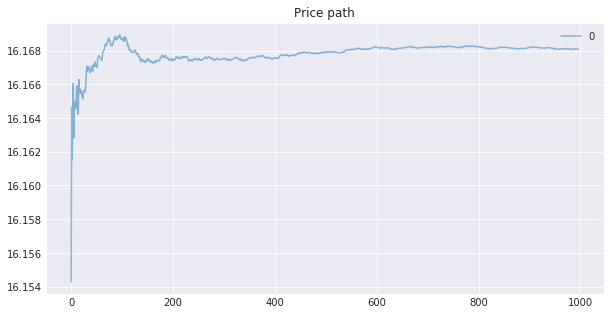

In [36]:
# Price path
data=pd.DataFrame([x[1] for x in p_list[3:1000]])
data.plot(figsize=(10,5), alpha=0.5, title='Price path');

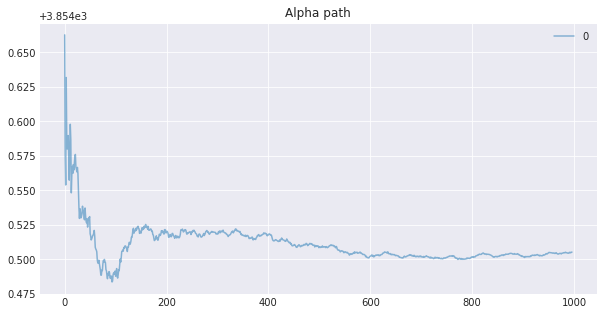

In [37]:
# Alpha path
data=pd.DataFrame([x for x in alpha_list[3:1000]])
data.plot(figsize=(10,5), alpha=0.5, title='Alpha path');

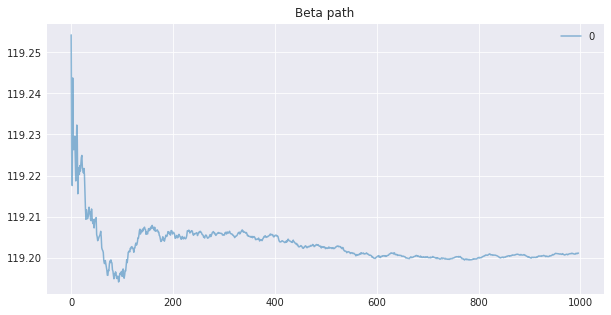

In [38]:
# Beta path
data=pd.DataFrame([x for x in beta_list[3:1000]])
data.plot(figsize=(10,5), alpha=0.5, title='Beta path');

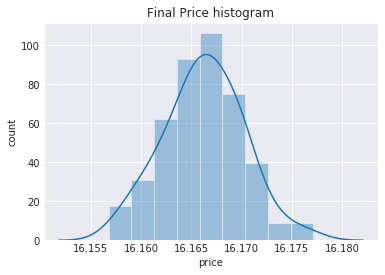

In [39]:
# Price histogram
ax = sns.distplot(final_p)
ax.set(xlabel='price', ylabel='count', title='Final Price histogram');

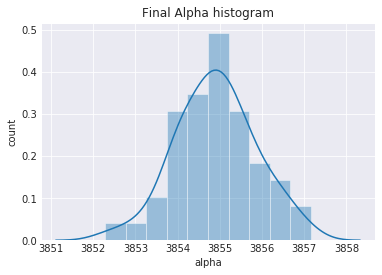

In [40]:
# Alpha histogram
ax = sns.distplot(final_alpha)
ax.set(xlabel='alpha', ylabel='count', title='Final Alpha histogram');

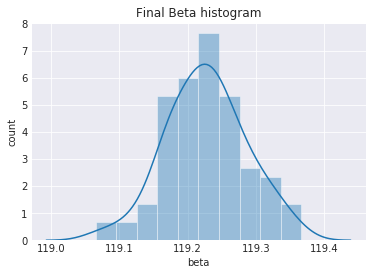

In [41]:
# Beta histogram
ax = sns.distplot(final_beta)
ax.set(xlabel='beta', ylabel='count', title='Final Beta histogram');

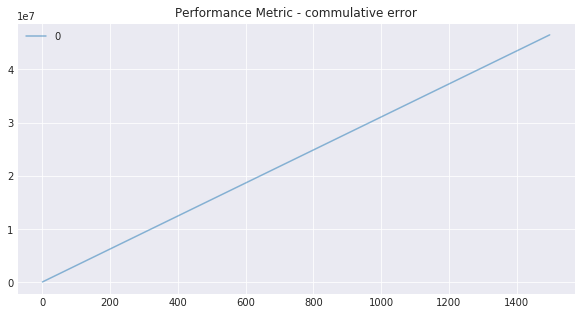

In [42]:
# Performance metric
data=pd.DataFrame(perf_metric)
data.plot(figsize=(10,5), alpha=0.5, title='Performance Metric - commulative error');

### Online learning by querying from real dataset

Now we can do something more interesting. In the last algorithm everytime we want to generate a new {price,demand} pair to recalculate our alpha and beta we ask a linear model with noise to generate that pair (we give the price we want and it returns the demand). But that seems strange when we have a realistic dataset, why would we run an online algorithm on simulated data coming from a linear model that was fitted on the original data? Why don't we run an online algorithm that uses {price,demand} pairs from the original dataset?  

That seems more like a real life situation. At every time step the online algorithm decides that he needs the demand value of a speficic price, we then as business owners change the price to the price the algorithm told us and let the market tell us what is the demand. That way we construct {price,demand} pairs in a real online learning fashion.  

Also, we waw that the algorithm above decides that the optimal price is about 14 per kilometer. It seems strange, we don't even have a single point of data above 6 USD to check if it makes sense. This happens because the algorithm runs on simulated data from a linear model that has no boundaries, it can return a demand value for any price that you give it, even negative prices. If we instead use the real dataset to get the pairs and set the necesarry boundaries we can force the algorithm to find the optimal price inside the range of the experiment. That also makes more sense as business owners.

So how can we do that? Everytime the algorithm asks us for the demand of a given price that he decides we go the the original dataset (equivalent to "go check the market" in real life) and find the demand of the price that is closest to the requested price. For example if the algorithm asks us what is the demand for price 2.265 USD we might not have that information, so we return the closest pair {2.27,1245}. That way the algorithm has the most similar information to what he needed. In the case that the algorithm ask us for the demand of a price that is below the minimum price or above the maximum price we just return him a random {price,demand} pair.  

This way the algorithm should arrive to the same alpha and beta conclusions without going through a linear model that looks at all the data first. Also, it should arrive to the optimal price INSIDE the range of the dataset, not some extreme value like 14 USD per kilometer. Disclaimer: The fact that we get 14 USD and not something more reasonable is because our dataset doesn't really fit a linear model, and even when we force it to fit it we get a super inelastic demand function.

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
import random

# Initial Parameters
alpha = sm.OLS(df_demand['sum'], sm.add_constant(df_demand['mean'])).fit().params[0]
beta = -sm.OLS(df_demand['sum'], sm.add_constant(df_demand['mean'])).fit().params[1]
initial_p = 2

df_demand_sorted = df_demand.sort_values(by='mean', ascending=True)
minPrice = df_demand_sorted['mean'].min()
maxPrice = df_demand_sorted['mean'].max()

# Function that returns the closes price to the queryed one and the demand for that query 
def model(price):
    if ((price < maxPrice) & (price > minPrice)):
        idx = df_demand_sorted['mean'].sub(price).abs().idxmin()
        return [df_demand_sorted.loc[idx]['mean'], df_demand_sorted.loc[idx]['sum']]
    else:
        rand_price = random.uniform(minPrice, maxPrice)
        return model(rand_price)

# Regression function
def regression(p_list, D_list):
    reg = LinearRegression(fit_intercept=False).fit(p_list, D_list)
    return reg.coef_

# Performance accummulator
def performance(perf_last,p_val):
    return perf_last - (beta-p_val*(alpha-beta*p_val))

final_p = []
final_alpha = []
final_beta = []
perf_record = []

num_iterations = 1500
num_expriments = 100

for j in range(num_expriments):
  
    # Initialize
    p_list = [[1,initial_p], [1,2*initial_p]]
    D_list = [model(initial_p)[1], model(2*initial_p)[1]]
    coef = regression(p_list, D_list)
    alpha_list = [coef[0]]
    beta_list = [-coef[1]]
    perf_metric = [0]

    # Run
    for i in range(num_iterations):
        query = alpha_list[-1]/(2*beta_list[-1])
        vals = model(query)
        p_list.append([1,vals[0]])
        D_list.append(vals[1])
        coef = regression(p_list, D_list)
        alpha_list.append(coef[0])
        beta_list.append(-coef[1])
        if i>=2:
            perf_metric.append(performance(perf_metric[-1],p_list[-1][1]))
      
    # Save final price, alpha and beta of iteration
    final_p.append(p_list[-1][1])
    final_alpha.append(alpha_list[-1])
    final_beta.append(beta_list[-1])

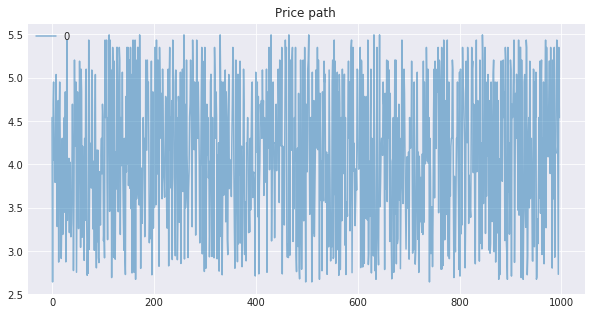

In [44]:
# Price path
data=pd.DataFrame([x[1] for x in p_list[3:1000]])
data.plot(figsize=(10,5), alpha=0.5, title='Price path');

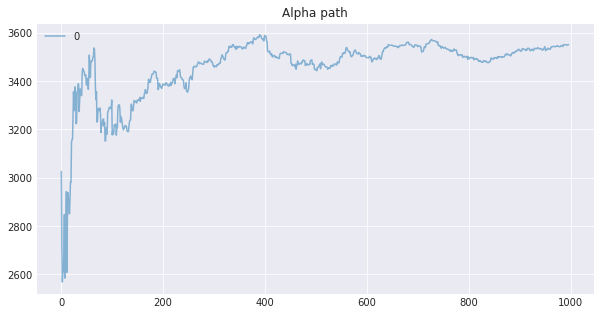

In [45]:
# Alpha path
data=pd.DataFrame([x for x in alpha_list[3:1000]])
data.plot(figsize=(10,5), alpha=0.5, title='Alpha path');

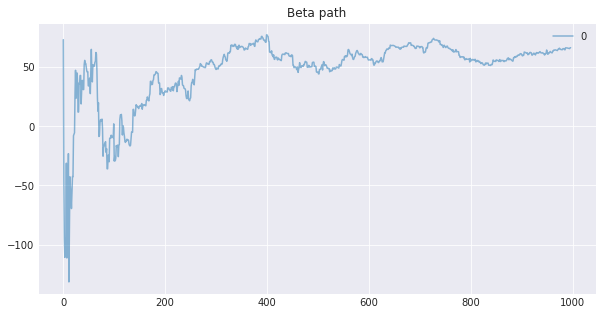

In [46]:
# Beta path
data=pd.DataFrame([x for x in beta_list[3:1000]])
data.plot(figsize=(10,5), alpha=0.5, title='Beta path');

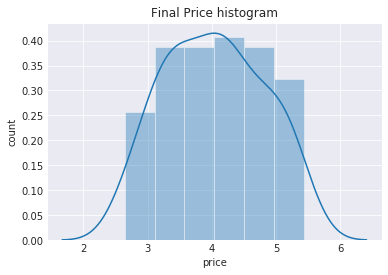

In [47]:
# Price histogram
ax = sns.distplot(final_p)
ax.set(xlabel='price', ylabel='count', title='Final Price histogram');

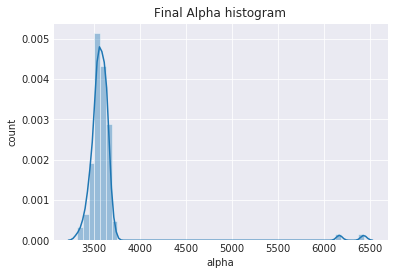

In [48]:
# Alpha histogram
ax = sns.distplot(final_alpha)
ax.set(xlabel='alpha', ylabel='count', title='Final Alpha histogram');

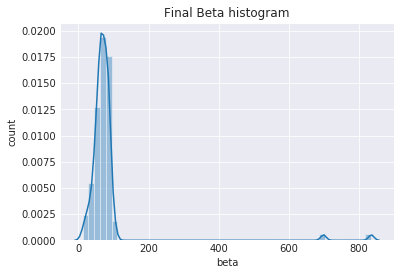

In [49]:
# Beta histogram
ax = sns.distplot(final_beta)
ax.set(xlabel='beta', ylabel='count', title='Final Beta histogram');

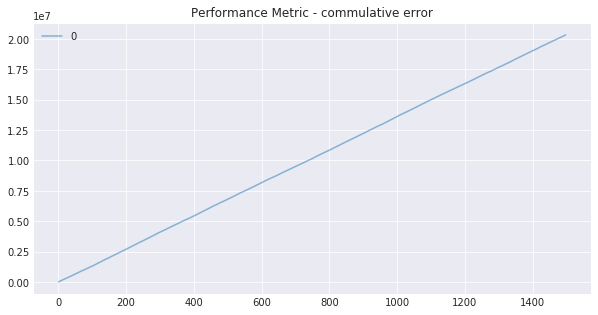

In [50]:
# Performance metric
data=pd.DataFrame(perf_metric)
data.plot(figsize=(10,5), alpha=0.5, title='Performance Metric - commulative error');

It may seem like the plots of the online algorithm based on the data from the linear model simulation are much better and smoother than the ones from online algorithm from real data. But of course, in the first case we had to go though the entire dataset to get the linea model coefficients and then we simulate data coming from a linear model with perfect gaussian noise with mean 0 and variance 1, a very unrealistic situation. On the second case instead we never went though the entire dataset, with just a well chosen sample we get to similar values of alpha and beta.